 # ShipSet Model Training

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import glob
import PIL
import PIL.Image as Image
import tqdm
import time
import os

import sklearn.model_selection

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

# Config

In [2]:
N_FOLDS=10

TRAIN_BATCH_SIZE=4
TEST_BATCH_SIZE=4

CRITERION=torch.nn.CrossEntropyLoss()

EPOCHS=10

OPTIMIZER="SGD"
OPTIMIZER_PARAMS={"lr":0.01,"momentum":0.9}

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

MODEL_SAVE_DIR="models"

EARLY_STOP=3 #after this many epochs, early stop if no improvement has happened

In [3]:
os.makedirs(MODEL_SAVE_DIR,exist_ok=True)

# Load Dataset

In [4]:
f = open("Data\shipsnet.json")
 
# returns JSON object as
# a dictionary
dataset = json.load(f)


In [5]:
Images=np.reshape(np.array(dataset['data']),(4000,3,80,80)).astype('uint8')


In [6]:
labels=np.array(dataset['labels'])

## Create Dataset

In [7]:
class ShipSet(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: a np array of the images
        labels: the labels for each image
        transforms: the transforms used to transform each image, this will be necessary because the
        dataset is very small, only 4,000 images
        """
        self.images=torch.from_numpy(images)
        self.labels=labels
        self.transform=transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        
        image=self.images[index]
        label=self.labels[index]
        
        if self.transform:
            image=self.transform(image)
        
        return image,label
        
        

As a test, lets have our custom dataset display some images, to do that let us write a function to display the images together as one matplotlib figure, this will also come in handy when we begin to experiment with transforms

In [8]:
def display_images(dataset, indexs):
    fig,axs=plt.subplots(ncols=len(indexs),figsize=(10,10*len(indexs)))
    
    for i, index in enumerate(indexs):
        image, label=dataset[index]
        axs[i].imshow(image.T.numpy())
        axs[i].axis('off')
        if label==1:
            axs[i].title.set_text("ship")
        else:
            axs[i].title.set_text("not ship")
        



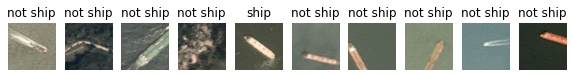

In [9]:
testSet=ShipSet(Images,labels)
display_images(testSet, np.random.choice(np.arange(len(testSet)),size=10))

# Writing the Train and Val Functions

In [10]:
def train_once(model,trainLoader,optimizer,
               criterion,device='cpu',
               print_loss=True,print_accuracy=True):
    
    start_time=time.time()
    total_loss=0
    n_correct=0
    n_total=0
    for batch in trainLoader:
        Images=batch[0].to(device)
        Labels=batch[1].to(device).long()
        #print(Labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(Images)
        loss = criterion(outputs, Labels)
        loss.backward()
        optimizer.step()
        
        #record loss and accuracy
        total_loss+=loss.item()
        n_correct=torch.sum(torch.argmax(outputs, axis=1)==Labels).item()
        n_total=Labels.shape[0]
    
    print(f"time:{round(time.time()-start_time,2)}s",end="|")
    if print_loss:
        print(f"train loss={round(total_loss/n_total,5)}",end="|")
    if print_accuracy:
        print(f"train accuracy={round(n_correct/n_total,4)}",end="|")
    

In [11]:
def val(model,valLoader,device="cpu"):
    
    label_true=[]
    label_pred=[]
    with torch.no_grad():
        for batch in valLoader:
            Images=batch[0].to(device)
            Labels=batch[1]
            # calculate outputs by running images through the network
            outputs = model(Images).cpu().detach()
            
            #record predictions and truths
            label_true+=Labels.tolist()
            label_pred+=torch.max(outputs.data, 1)[1].tolist()
    return label_true,label_pred

# Helper functions to create the model and optimizer

In [12]:
def create_model():
    model=torchvision.models.resnet18(pretrained=False)
    model.fc=torch.nn.Linear(512,2)
    return model

In [13]:
def create_optimizer(model,optimizer_name,optimizer_params):
    if optimizer_name=="SGD":
        return optim.SGD(model.parameters(),**optimizer_params)

# Create Transforms

Because the dataset is so small we will have to transform the dataset. To do this I will be using the transforms found in the torchvision.transforms library

In [14]:
transform=T.Compose([
    T.RandomRotation(180),
    T.ConvertImageDtype(torch.float32)
])

To understand how this would alter the images, let us plot a sample of untransformed and transformed images

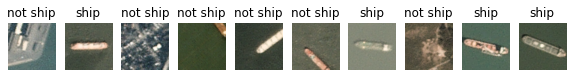

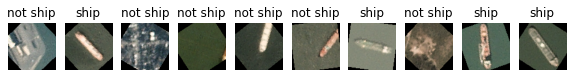

In [15]:
testSetTransfom=ShipSet(Images,labels,transform=transform)
indexs=np.random.choice(np.arange(len(testSet)),size=10)
display_images(testSet, indexs)
display_images(testSetTransfom, indexs)

# Main Routine

In [16]:
def main():
    kf = sklearn.model_selection.KFold(n_splits=N_FOLDS,shuffle=True)
    fold=1
    for train_index, test_index in kf.split(labels):
        print(f"----------fold {fold}----------")
        trainSet=ShipSet(Images[train_index],labels[train_index],transform=transform)
        valSet=ShipSet(Images[test_index],labels[test_index],
                      transform=T.ConvertImageDtype(torch.float32))
        
        
        trainLoader=DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        valLoader=DataLoader(valSet, batch_size=TEST_BATCH_SIZE, shuffle=True)
        
        model=create_model()
        model.to(DEVICE)
        optimizer=create_optimizer(model,OPTIMIZER,OPTIMIZER_PARAMS)
        
        best_accuracy=0
        epochs_without_improvment=0
    
        
        
        for epoch in range(EPOCHS):
            print(f"epoch {epoch+1}",end=" ")
            train_once(model,trainLoader,optimizer,
               CRITERION,device=DEVICE)
            
            label_true,label_pred=val(model,valLoader,device=DEVICE)
            
            accuracy=sklearn.metrics.accuracy_score(label_true, label_pred)
            print(f"val accuracy={accuracy}")
            
            epochs_without_improvment+=1
            if accuracy>best_accuracy:
                best_accuracy=accuracy
                torch.save(model,f'{MODEL_SAVE_DIR}/fold{fold}.pt')
                epochs_without_improvment=0
                
                
            if epochs_without_improvment==EARLY_STOP:
                print(f"early stopping because the val accuracy has not improved for {EARLY_STOP} epochs")
                break
            
            #break
        fold+=1
            
            
        
        
        
        
        
    

In [17]:
main()

----------fold 1----------
epoch 1 

C:\Users\Lawrence\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


time:17.14s|train loss=176.75872|train accuracy=1.0|val accuracy=0.9275
epoch 2 time:16.82s|train loss=42.42161|train accuracy=1.0|val accuracy=0.9575
epoch 3 time:16.19s|train loss=42.90245|train accuracy=1.0|val accuracy=0.9775
epoch 4 time:15.31s|train loss=31.31192|train accuracy=1.0|val accuracy=0.95
epoch 5 time:15.35s|train loss=35.27674|train accuracy=1.0|val accuracy=0.95
epoch 6 time:15.2s|train loss=26.65735|train accuracy=0.75|val accuracy=0.9625
early stopping because the val accuracy has not improved for 3 epochs
----------fold 2----------
epoch 1 time:16.12s|train loss=121.80367|train accuracy=1.0|val accuracy=0.8975
epoch 2 time:15.1s|train loss=60.98789|train accuracy=1.0|val accuracy=0.9675
epoch 3 time:15.98s|train loss=29.98794|train accuracy=0.75|val accuracy=0.96
epoch 4 time:14.97s|train loss=26.9678|train accuracy=1.0|val accuracy=0.9575
epoch 5 time:14.95s|train loss=33.04171|train accuracy=1.0|val accuracy=0.9775
epoch 6 time:14.76s|train loss=19.17663|train a